# Data Science en pratique

Arthur Llau, arthur@flowlity.com

# Cours 9 : Introduction à la classification d'images

Avant tout, des sources :
- CS231 Stanford : http://cs231n.github.io/ 
- Deep Learning Book : http://www.deeplearningbook.org/ 

Le cours suivant porte uniquement sur la classification d'image avec des réseaux dits de convolution (CNN).

La littérature autour de cette problématique propose beaucoup d'autres architectures que je vous laisse le soin d'explorer.


Plan du cours :
- **1** Contexte et Problématique
- **2** Rappel sur les CNN et keras
- **3** Premier CNN
- **4** Cifar10

## 0 - Computer Vision

## 1.0 Intro

La vision assistée par ordinateur est un ensemble de systèmes permettant de manipuler des images dans le but de résoudres différentes problématiques/

Voici une liste - partielle - des tâches possibles en computer vision:
- Depth Estimation
- Image Classification
- Object Detection
- Image Segmentation
- Image Generation
- Video Classification
- Zero-Shot Image Classification
- Mask Generation
- Zero-Shot Object Detection

In [1]:
import matplotlib.pyplot as plt
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests
from PIL import Image, ImageDraw
import matplotlib.patches as patches

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
draw = ImageDraw.Draw(image)
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes


# print results
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.91, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    class_label = model.config.id2label[label.item()]
    confidence = round(score.item(), 3)

    # Draw rectangle
    draw.rectangle(box, outline="red")
    
    # Add text
    text = f"{class_label}: {confidence}"
    text_width, text_height = 4, 4#draw.textsize(text)
    text_location = [box[0], box[1] - text_height - 4]
    draw.rectangle([text_location[0], text_location[1], text_location[0] + text_width, text_location[1] + text_height], fill="red")
    draw.text(text_location, text, fill="white")



The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Exemple d'object detection

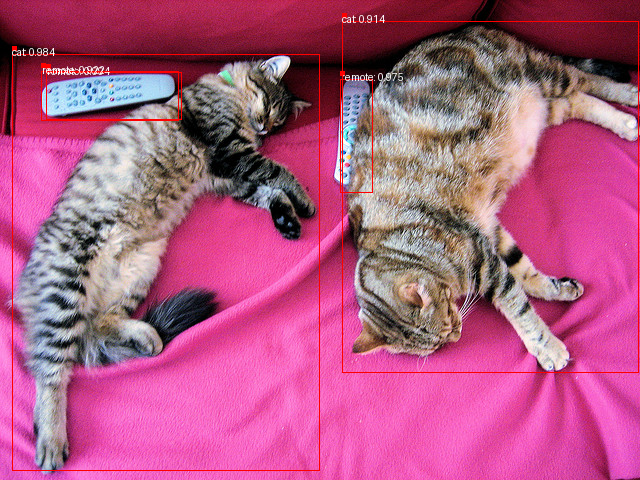

In [2]:
image

In [3]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

url = "https://img.nrj.fr/8dBr719gm_LGhoOgskFRQJzIiVQ=/medias%2F2023%2F07%2F5bfomqk0ggytfrptc-dofltxxqycuvoftkizy-0ycs_64ae8452c6738.png"

image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]


/home/arthur/anaconda3/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


Un exemple de segmentation d'images

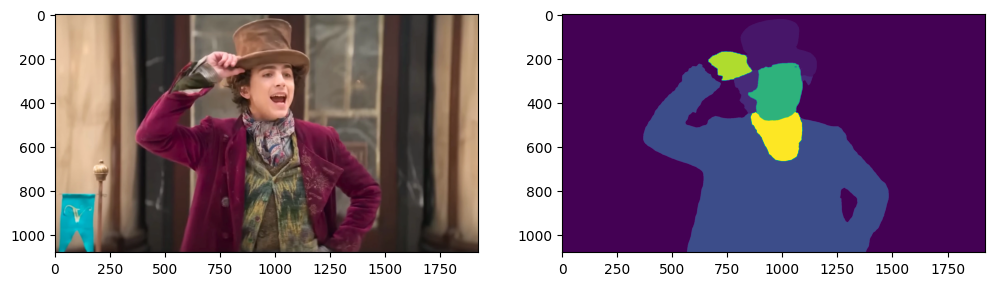

In [4]:
figs, axs=plt.subplots(ncols=2, figsize=(12,12))
axs[0].imshow(image)
axs[1].imshow(pred_seg)

In [7]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

url = 'https://www.zooplus.fr/magazine/wp-content/uploads/2022/01/cocker-spaniel-1-1024x678.jpeg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()


Predicted class: cocker spaniel, English cocker spaniel, cocker


Predicted class: cocker spaniel, English cocker spaniel, cocker


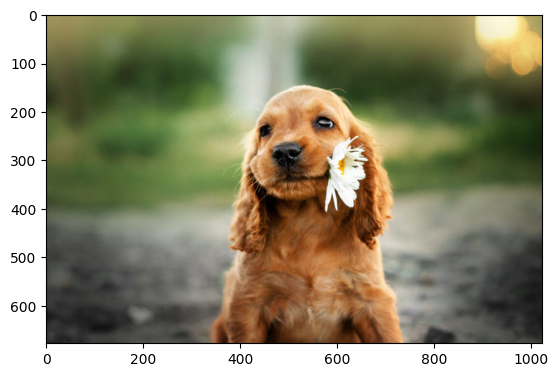

In [8]:
plt.imshow(image)
print("Predicted class:", model.config.id2label[predicted_class_idx])

# 1. Contexte et problématique

### 1.1 - Contexte

![](chocolatine.jpg)


Il est facile à l'oeil nu de reconnaitre la différence entre un paresseux et une chocolatine, en tout cas sur 16 images. Mais imaginez qu'il faille le faire sur 20 millions d'images. En plus d'être une tache particulièrement pénible, la fatigue peut nous amener à nous tromper. D'où l'utilité d'automatiser la tâche et donc de construire un algorithme d'apprentissage automatique.  

### 1.2 -  Problématique du cours - exercice basique


Grand classique de la classification d'images voici le jeu de données MNIST. Il représente des chiffres manuscrit que l'on peut retrouver sur des courriers ou bien des chèques. Une des premières apparitions de la classification d'images repose sur la problématique de reconnaitre ces chiffres manuscrits. C'est Yann LeCun (FAIR, NYU) qui a le premier developpé un modèle permettant de réaliser cette tâche : LeNet5. 

Le but de l'exercice suivant est de classifier ces chiffres manuscrits sans utiliser de techniques très avancées.

In [1]:
import keras
import warnings
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist, cifar10
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

/home/arthur/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

**1** Observez x_train, puis affichez 4 images aléatoirement avec le label correspondant.

In [3]:
print(x_train.shape)
print(x_train[0].shape)

(60000, 28, 28, 1)
(28, 28, 1)


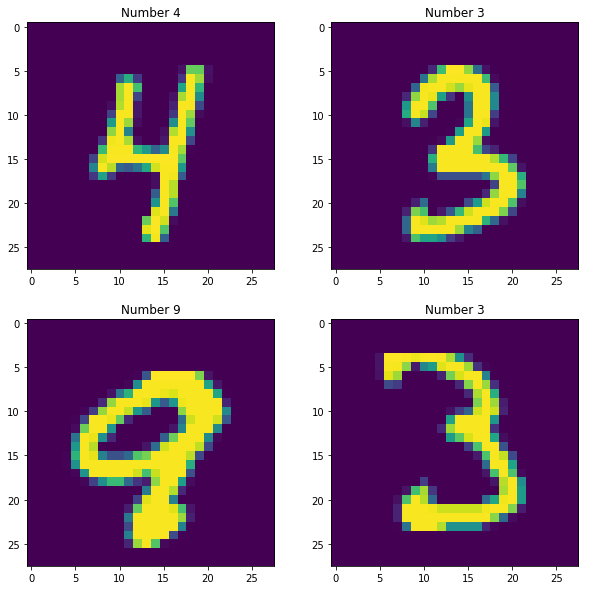

In [4]:
plt.figure(figsize=(10,10))
for j,i in enumerate(np.random.randint(0,x_train.shape[0],4)):
    plt.subplot(220+j+1)
    plt.imshow(x_train[i][:,:,0])
    plt.title('Number {}'.format(y_train[i]))

**2** Comment transformer les images de manières à les utiliser avec une régression logistique ? Faites le !

In [5]:
flatten_train = np.zeros((x_train.shape[0],28*28))
for i in range(x_train.shape[0]):
    flatten_train[i,:] = x_train[i].flatten()

In [6]:
print(flatten_train[1,:])

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  51. 159. 253. 159.  50.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  48. 238. 252. 252. 252. 237.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  54.
 227. 253. 252. 239. 233. 252.  57.   6.   0.   0.   0.   0.   0.   0.
   0. 

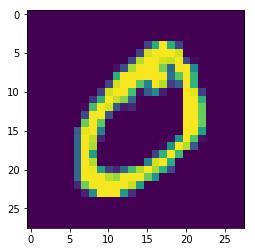

In [7]:
plt.imshow(flatten_train[1,:].reshape(28,28)) #On retrouve bien la transformation

**3** Évaluez les performances d'une régression logistique sur les 1000 première observations du jeu de données.

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

cv = cross_val_score(LogisticRegression(),flatten_train[:1000],y_train[:1000])
print ('Performance {:.3f} +/- {:.3f}'.format(cv.mean(),cv.std()))

Performance 0.826 +/- 0.013


On obtient directement 80% d'accuracy, ce qui est plutôt pas mal, mais peut-on faire mieux ?


## 2 - Vision et Keras

### 2.1 Architecture d'une image

In [9]:
import os
path = '/home/arthur/Bureau/DeepLearning/ImageClassification/CatVsDog/data/train/'
list_files = os.listdir(path)

Dimensions de l'image  (240, 232, 3)
A quoi correspondent ces valeurs ?


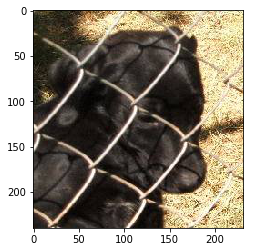

In [10]:
img = path + list_files[11]
image = plt.imread(img)

print ('Dimensions de l\'image ', image.shape)
print ('A quoi correspondent ces valeurs ?')

plt.imshow(image, interpolation='nearest')
plt.show()

Facile : Hauteur x Largeur x RGB. Nous sommes donc en possessions d'un objet en trois dimensions.

Affichez quelques images, que remarquez-vous qui peut paraitre embêtant?

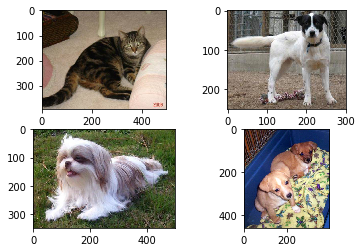

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2)

axs = ax.ravel()
for j,i in enumerate(np.random.choice(list_files,4)):
    img = path + i
    image = plt.imread(img)
    axs[j].imshow(image, interpolation='nearest')

plt.show()

On remarque plusieurs choses. Premièrement la taille des images est différente pour chaque photo, il faudra alors rogner celles-ci pour les uniformiser. Deuxièmement, l'animal n'est pas nécéssairement au centre de la photo. Et enfin, il apparait souvent d'autres éléments qui peuvent prendre une place importante dans l'image.

### 2.2 Différents types de couches


Nous avons vu qu'un réseau de neurones est constitué de multiples couches. Dans notre cadre, elles étaient toutes de type dense ou fully connected. Néanmoins, pour traiter des images nous allons avoir besoin d'un type réseau spécifique : les réseaux de convolution.

Un CNN n'est autre qu'un réseau de neurones disposant d'une ou plusieurs couches de convolution, ainsi que d'autres couches que nous allons détailler. L'idée est de ne plus regarder une image comme une suite de pixel mais comme un objet qui peut être détaillé et, à partir duquel on peut exraire de l'information.

#### 2.2.1 Couche de Convolution

Imaginons que l'on regarde une image en couleur comme une liste de pixels: on obtient alors un objet de taille : $$longueur*largeur*3$$.  C'est énorme pour une image, alors qu'en est-il pour un jeu de donnée d'un million d'images.

L'idée de la couche de convolution revient sur l'extraction d'informations d'une image à travers des filtres.

On va extraire de chaque image une "feature map" qui correspond à un pattern spécifique.


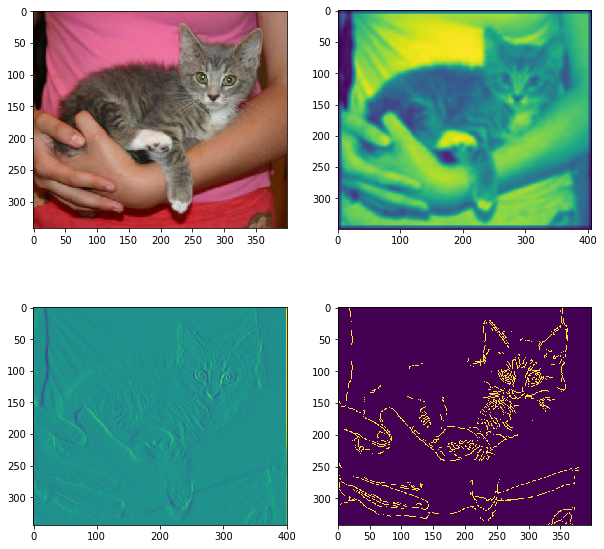

In [12]:
import cv2
from scipy.signal import convolve2d

img = path + list_files[14]
image = plt.imread(img)

kernel1 = kernel = np.ones((8,8), np.float32)/64
kernel2 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
image1 = convolve2d(image[:,:,0],kernel1)
image2 = convolve2d(image[:,:,0],kernel2)
image3 = cv2.Canny(image,100,200)

plt.figure(figsize=(10,10))
plt.subplot(221),plt.imshow(image);
plt.subplot(222),plt.imshow(image1);
plt.subplot(223),plt.imshow(image2);
plt.subplot(224),plt.imshow(image3);

#Que se passe-t'il ?

La couche de convolution fonctionne en plusieurs étapes :
- On applique un filtre de taille n*n\*3 (sur chaque channel) sur un échantillon de taille n*n de notre image.
- On calcule le produit d'Hadamard du filtre*échantillon, ce qui nous donne un nouveau feature.
- On effectue un shift et on recommence les deux étapes précédentes.
- Une fois l'image entièrement filtrée on obtient une feature map, i.e. une matrice de features extraits de l'image.

![](conv.png)


Généralement on se cantonne pas à un unique filtre, on en utilise une grande diversité. La feature map est alors à son tour un objet de taille n\*n\*nbFilters.
![](filters.png)



In [13]:
#Dans keras il s'agit pour une image de la couche conv2D
keras.layers.Conv2D(filters = 12, kernel_size = 3, strides=(1, 1))
print("""\tfilters : nombre de filtres \n
        kernel_size : taille du filtre \n
        strides : taille du shift""")


	filters : nombre de filtres 

        kernel_size : taille du filtre 

        strides : taille du shift


2D car il s'agit  de la dimension de sortie pour un filtre

#### 2.2.2 Couche de Pooling

La couche de Pooling, qui intervient généralement après une couche de convolution, permet de faire du down-sampling. On s'intéressera ici uniquement à l'opération dite de Max-pooling.![](pool.png)
Sur un carré de taille h*h on va choisir la valeur maximale, et l'exporter dans une nouvelle matrice.

Il y a plusieurs avantages à faire du Max-Pooling sur la feature map :
- Cela permet de réduire le nombre de paramètres du modèles.
- Contrôle de l'overfitting
- Invariant par petite transformation (on prend le max des features détectés)
- Gain de temps de calcul

In [14]:
keras.layers.MaxPooling2D(pool_size=(2, 2))
print('pool size : taille de la fenetre sur laquelle on prend le max')

pool size : taille de la fenetre sur laquelle on prend le max


#### 2.2.3 Couche de Correction / Normalisation

Les couches de correction  ne correspondent à rien d'autres qu'à des applications de fonction d'activation permettant d'introduire de la non-linéarité dans le réseau.

Les couches de normalisation, qui sont de moins en moins à la mode, permettent d'effectuer une normalisation des données entre des couches. Cela permet, entre autre, d'accélerer le learning.

### 2.3 Quelques exemples d'architecture

Voici quelques architectures classiques :
- INPUT->FC: un PMC 
- INPUT->CONV-RELU->FC: Un classifieur d’image simple
- INPUT->[CONV-RELU->POOL]*2->FC-RELU->FC: de même !


** "Don't be a hero. Don't reinvent the wheel. Use pre-trained networks!"**

Il existe de multiple architecture de réseaux pré-entrainés sur des bases de données d'images. C'est réseaux peuvent alors être tweaké et entrainé pour notre de problématique de manière à obtenir des bons résultats rapidemment.

On trouve par exemple (mes préférés):
- ResNet50 
- DenseNet201
- VGG-16
- InceptionResNet
- Xception
- ResNext
- MobileNet

Je vous invite grandement à vous penchez sur les papiers de ces articles pour bien comprendre leurs particularités respectives. 

![VGG19](vgg.png)

## 3. Premier CNN

In [15]:
from keras.models import Sequential
from keras.layers import Dropout, Dense,Flatten,Conv2D, MaxPool2D, BatchNormalization
from keras.utils import np_utils


**1** Nous allons tacher d'améliorer nos performances sur MNIST.
Reproduisez le modèle suivant  et affichez le: 

input = CONV-RELU (32) -> MaxPooling -> FLATTEN -> DENSE = Output

*Attention aux tailles d'input et d'output !*

In [16]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape = (img_rows,img_cols,1)))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(10, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


**2** Normaliser les données et binariser les targets (keras.utils : to_categorical).

In [17]:
x_train = x_train.astype('float32')
x_train /= 255
y_train = keras.utils.to_categorical(y_train, 10)


**3** Compilez le puis faites le apprendre sur les données pour 5 epochs. Enfin affichez la loss et la métrique.

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train,y_train, validation_split = 0.2, epochs=5)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 5s 105us/step - loss: 0.2380 - acc: 0.9318 - val_loss: 0.0998 - val_acc: 0.9729
Epoch 2/5
48000/48000 [==============================] - 3s 70us/step - loss: 0.0852 - acc: 0.9751 - val_loss: 0.0768 - val_acc: 0.9779
Epoch 3/5
48000/48000 [==============================] - 3s 70us/step - loss: 0.0642 - acc: 0.9810 - val_loss: 0.0680 - val_acc: 0.9803
Epoch 4/5
48000/48000 [==============================] - 4s 74us/step - loss: 0.0524 - acc: 0.9842 - val_loss: 0.0670 - val_acc: 0.9807
Epoch 5/5
48000/48000 [==============================] - 3s 71us/step - loss: 0.0445 - acc: 0.9861 - val_loss: 0.0624 - val_acc: 0.9813


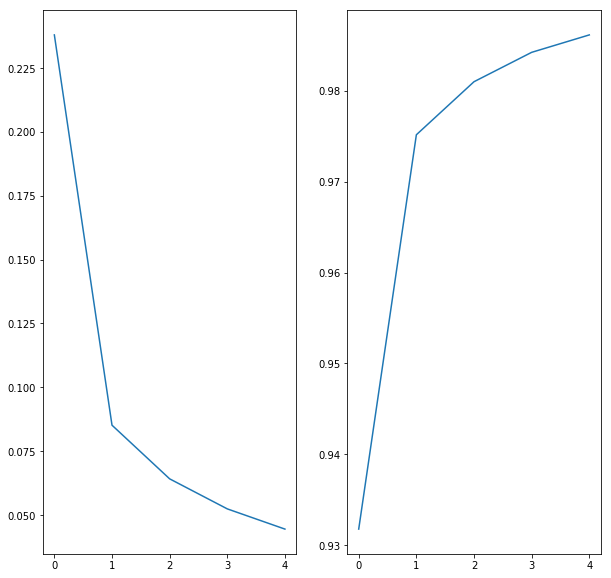

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.subplot(122)
plt.plot(history.history['acc'])

**4** Evaluez les performances sur le jeu de test.

In [20]:
from sklearn.metrics import accuracy_score
#On renormalise
x_test = x_test.astype('float32')
x_test /= 255
#on prédit
preds = model.predict(x_test)
print(preds)

[[4.3663282e-09 8.1130644e-08 1.9497507e-07 ... 9.9998915e-01
  2.7956510e-08 5.1513126e-07]
 [1.1755695e-06 2.8474315e-04 9.9913847e-01 ... 6.4623155e-12
  7.2646577e-07 6.9213225e-11]
 [5.2847267e-06 9.9952567e-01 3.4450070e-05 ... 1.5518469e-04
  7.7788507e-05 1.0476805e-06]
 ...
 [3.4591476e-11 4.3959401e-09 9.8008890e-10 ... 4.3110081e-06
  4.3895920e-06 1.8019704e-05]
 [6.3164376e-09 2.5033211e-09 1.3920913e-09 ... 1.4992821e-08
  6.2035641e-04 1.7713942e-08]
 [6.5928361e-08 2.7768737e-11 1.6127761e-06 ... 4.7466062e-11
  1.8996469e-07 1.8445146e-12]]


In [21]:
#On alors besoin de l'argmax pour récupérer les proba

preds = np.argmax(preds,axis= 1)
print('Performance CNN simple {}'.format(accuracy_score(y_test,preds)))

Performance CNN simple 0.9814


**5** En vous inspirant du CNN précédent, faites mieux !

In [22]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape = (img_rows,img_cols,1)))
model.add(MaxPool2D())
model.add(Conv2D(filters=32, kernel_size=(2,2), activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        8224      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               147584    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
__________

In [23]:
history = model.fit(x_train,y_train, validation_split = 0.2, epochs=5)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 6s 123us/step - loss: 0.1697 - acc: 0.9489 - val_loss: 0.0712 - val_acc: 0.9762
Epoch 2/5
48000/48000 [==============================] - 6s 118us/step - loss: 0.0547 - acc: 0.9830 - val_loss: 0.0512 - val_acc: 0.9834
Epoch 3/5
48000/48000 [==============================] - 6s 128us/step - loss: 0.0372 - acc: 0.9881 - val_loss: 0.0448 - val_acc: 0.9882
Epoch 4/5
48000/48000 [==============================] - 6s 124us/step - loss: 0.0288 - acc: 0.9905 - val_loss: 0.0392 - val_acc: 0.9887
Epoch 5/5
48000/48000 [==============================] - 6s 120us/step - loss: 0.0206 - acc: 0.9933 - val_loss: 0.0440 - val_acc: 0.9886


In [24]:
preds = model.predict(x_test)
preds = np.argmax(preds,axis= 1)
print('Performance CNN simple {}'.format(accuracy_score(y_test,preds)))

Performance CNN simple 0.9892


## 4 - CIFAR 10

In [25]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


**1** Affichez les 4 premières images. Quelles sont les différences avec les images précédentes ?
Combien il y a t'il de classes ?

Nombre de classes : 10


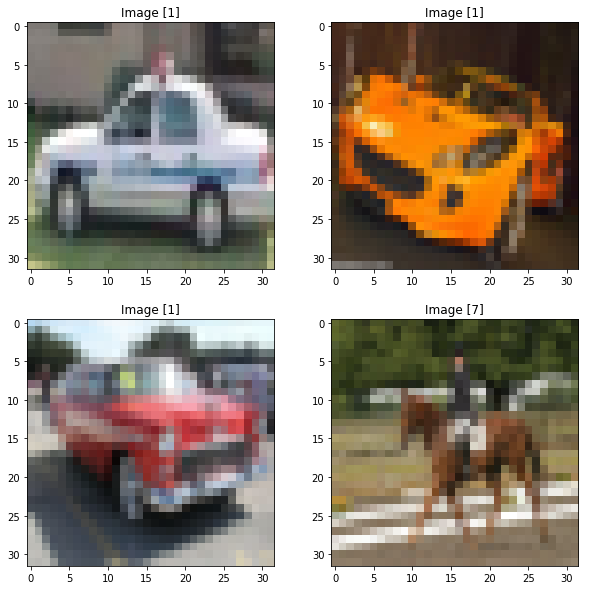

In [26]:
print('Nombre de classes : {}'.format(len(np.unique(y_train))))
plt.figure(figsize=(10,10))
for j,i in enumerate(np.random.randint(0,x_train.shape[0],4)):
    plt.subplot(220+j+1)
    plt.imshow(x_train[i][:,:])
    plt.title('Image {}'.format(y_train[i]))

Les images sont de tailles 32x32 contre 28x28

**2** Désignez, en premier lieu, un ConvNet simple permettant d'obtenir de bonnes performances sur le jeu de test.

In [27]:
#D'abord on rescale et on prépare les targets
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = np_utils.to_categorical(y_train)

In [28]:

model = Sequential()
model.add(Conv2D(64, (3, 3),input_shape=x_train.shape[1:], activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1000, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              1153000   
__________

In [29]:
history = model.fit(x_train,y_train, validation_split = 0.2, epochs=10)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 8s 212us/step - loss: 1.4591 - acc: 0.4733 - val_loss: 1.1888 - val_acc: 0.5776
Epoch 2/10
40000/40000 [==============================] - 8s 207us/step - loss: 1.1338 - acc: 0.5975 - val_loss: 1.0441 - val_acc: 0.6336
Epoch 3/10
40000/40000 [==============================] - 8s 206us/step - loss: 0.9786 - acc: 0.6552 - val_loss: 0.9873 - val_acc: 0.6546
Epoch 4/10
40000/40000 [==============================] - 8s 205us/step - loss: 0.8531 - acc: 0.7008 - val_loss: 0.9054 - val_acc: 0.6899
Epoch 5/10
40000/40000 [==============================] - 8s 207us/step - loss: 0.7296 - acc: 0.7442 - val_loss: 0.8639 - val_acc: 0.7105
Epoch 6/10
40000/40000 [==============================] - 8s 206us/step - loss: 0.6310 - acc: 0.7793 - val_loss: 0.8693 - val_acc: 0.7078
Epoch 7/10
40000/40000 [==============================] - 8s 205us/step - loss: 0.5418 - acc: 0.8093 - val_loss: 0.8769 - 

In [30]:
preds = model.predict(x_test)
preds = np.argmax(preds,axis= 1)
print('Performance CNN simple {}'.format(accuracy_score(y_test,preds)))

Performance CNN simple 0.6814


**3** Comment pourrait-on améliorer les performances ?

- Better model
- More data, more epochs, more layers
- Data Augmentation
- Pretrained models

In [33]:
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D

base_model = MobileNet(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train,y_train, validation_split = 0.2, epochs=3)


17227776/17225924 [==============================] - 8s 0us/step
Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 44s 1ms/step - loss: 1.1767 - acc: 0.6060 - val_loss: 0.9004 - val_acc: 0.6972
Epoch 2/3
40000/40000 [==============================] - 37s 919us/step - loss: 0.8410 - acc: 0.7256 - val_loss: 0.7893 - val_acc: 0.7288
Epoch 3/3
40000/40000 [==============================] - 37s 929us/step - loss: 0.7375 - acc: 0.7585 - val_loss: 0.6693 - val_acc: 0.7762


In [34]:
preds = model.predict(x_test)
preds = np.argmax(preds,axis= 1)
print('Performance MobileNet {}'.format(accuracy_score(y_test,preds)))

Performance MobileNet 0.7729
